# Final Project Machine Learning

## Juan David Sanchez & Alejandro Gil

### Enfasís en Análitica Aplicada


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
from typing import Callable
from functools import wraps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from prefect import flow, task, get_run_logger
from sklearn import metrics 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE



In [4]:
def timing_decorator(func: Callable) -> Callable:
    '''Custom decorator to time task execution'''
    @wraps(func)
    def wrapper(*args, **kwargs):
        logger = get_run_logger()
        start_time = time.time()

        # Execute the original function
        result = func(*args, **kwargs)

        end_time = time.time()
        execution_time = end_time - start_time

        logger.info(f"Task '{func.__name__}' completed in {execution_time:.2f} seconds")
        return result

    return wrapper

In [5]:
@task
@timing_decorator
def load_data() -> pd.DataFrame:
    df = pd.read_csv('dataset_full.csv')
    df.head(5)
    return df

In [6]:
@task
@timing_decorator
def smote(X_train, y_train):
    logger = get_run_logger()
    
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("Class Distribution:")
    class_dist = pd.Series(y_train_balanced).value_counts()
    ax = class_dist.plot(kind='bar')
    plt.title('Class distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', padding=1.5, fontsize=10, color='black')
    plt.show()
    
    logger.info(f"SMOTE aplicado: {X_train.shape[0]} -> {X_train_balanced.shape[0]} muestras")
    
    return X_train_balanced, y_train_balanced

In [7]:
@task
@timing_decorator
def distribution_plotter(df):
    print("Class Distribution:")
    class_dist = df['phishing'].value_counts()
    ax = class_dist.plot(kind='bar')
    plt.title('Class distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', padding=1.5, fontsize=10, color='black')
    plt.show()

    print("\nPercentage Distribution:")
    perc_dist = df['phishing'].value_counts(normalize=True) * 100
    perc_dist.plot(
            kind='pie',
            autopct='%1.1f%%',  
            startangle=90,        
            shadow=True,         
            colormap='tab20'      
        )
    plt.title('Percentage distribution')
    plt.ylabel('Count')  
    plt.show()

In [8]:
@task
@timing_decorator
def descriptor(df):
    print(f"Total missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate: {df.duplicated().sum()}\n")
    print(df.describe().T)


#### Correlation

In [9]:
@task
@timing_decorator
def correlation(df):
    correlation = df.corr()['phishing'].sort_values(ascending=False)

    top_corr = correlation[1:16]
    print(top_corr)

    top_corr.plot(kind='barh')
    plt.title('15 characteristics most correlated with phishing')
    plt.xlabel('Correlation')
    plt.show()

In [10]:
@task
@timing_decorator
def preprocessing(df):
    X = df.drop('phishing', axis=1) 
    y = df['phishing']

    print(f"\nX (Features): {X.shape}")
    print(f"y (Target): {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape))
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))

    return X_train, X_test, y_train, y_test


In [11]:
@task
@timing_decorator
def confusion_matrix(class_names, model, X_test, y_test):
 
    print("Visualización de desempeño con Matriz de Confusión:")
    y_pred = model.predict(X_test)
  
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None
    )
 
    disp.ax_.set_title("Confusion Matrix")
    print("Confusion Matrix")
    print(disp.confusion_matrix)
 
    plt.show()

In [12]:
@task
@timing_decorator
def show_classificationreport(model, X_test, y_test, class_names=None):
    
    y_pred = model.predict(X_test)

    # classification_report expects target_names to be an iterable of strings or None
    if class_names is not None:
        try:
            # convert each name to string to avoid TypeError when names are ints
            target_names = [str(c) for c in class_names]
        except Exception:
            target_names = None
    else:
        target_names = None

    print("Clasification Report")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    
    return report

In [13]:
@task
@timing_decorator
def roc_curve_analysis(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else: 
        y_scores = model.decision_function(X_test)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_scores)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()
    
    return roc_auc

In [14]:
@task
@timing_decorator
def multiple_roc(models_dict, X_test, y_test):
    plt.figure()
    for model_name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else: 
            y_scores = model.decision_function(X_test)
        
        fpr, tpr, _ = metrics.roc_curve(y_test, y_scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.show()

In [15]:
@task
@timing_decorator
def plot_learning_curve(model, X_train, y_train, model_name):
    """Graficar curva de aprendizaje - versión simple"""
    
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Train', linewidth=2)
    plt.plot(train_sizes, val_mean, 'o-', label='Validation', linewidth=2)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
@task
@timing_decorator
def bar_chart(models_dict, X_test, y_test):
    accuracies = {}
    for model_name, model in models_dict.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[model_name] = acc

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Model Accuracy Comparison')
    for i, v in enumerate(accuracies.values()):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
    plt.show()

#### Gradient Boosting

In [17]:
@task
@timing_decorator
def gradient_boosting(X_train, X_test, y_train, y_test):

    print("Gradient Boosting") 
    gb_model = GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

   
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())

    cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)
    print(f"\nResultados de la validación cruzada en gradient boosting:: {cv_scores}")
    print(f"Resultado promedio de la validación cruzada en gradient boosting:: {np.average(cv_scores):.4f}")

    print("Exactitud (accuracy) en prueba (testing) del gradient boosting:", metrics.accuracy_score(y_test, y_pred))

    return gb_model

#### Random Forest

In [18]:
@task
@timing_decorator
def random_forest(X_train, X_test, y_train, y_test):
    
    print("Random Forest") 

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    print(f"\nResultados de la validación cruzada en Random Forest: {cv_scores}")
    print(f"Resultado promedio de la validación cruzada en Random Forest: {np.average(cv_scores):.4f}")
    print("Exactitud (accuracy) en prueba (testing) del Random Forest:", metrics.accuracy_score(y_test, y_pred))
    
    return rf_model

#### Knn

In [19]:
@task
@timing_decorator
def knn(X_train, X_test, y_train, y_test):
    
    print("Knn") 
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)

    print("Comparación de hiperparámetros:")
    for k in [1, 3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        acc = knn.score(X_test, y_test)
        print(f"KNN (n_neighbors={k}) - Prueba de accuracy: {acc:.4f}")
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
    
    print("Score sobre el conjunto de test: {:.3f}".format(knn.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    #Validación cruzada datos entrenamiento 
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    print(cv_scores)
 
    print("Desempeño promedio del kNN:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing) del kNN:", metrics.accuracy_score(y_test, y_pred))
    
    return knn 

In [20]:
@task
@timing_decorator
def knn_scaler(X_train, X_test, y_train, y_test):
    
    print("Knn Scaler") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    knn_scaled = KNeighborsClassifier(n_neighbors=5)
    knn_scaled.fit(x_train_scaler, y_train)
    y_pred = knn_scaled.predict(x_test_scaler)
    
    comparacion_df = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    for k in [1, 3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_scaler, y_train)
        acc = knn.score(x_test_scaler, y_test)
        print(f"KNN Scaler(n_neighbors={k}) - Prueba de accuracy: {acc:.4f}")
    
    print("Comparación de predicciones:")
    print(comparacion_df.head())
 
    print("Score sobre el conjunto de test: {:.3f}".format(knn_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(knn_scaled, x_train_scaler, y_train, cv=5)
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing):", metrics.accuracy_score(y_test, y_pred))
 
    
    return knn_scaled, x_test_scaler

#### SVM


In [21]:
@task
@timing_decorator
def svm(X_train, X_test, y_train, y_test):
    
    print("SVM") 
    svm_class = SVC(kernel='rbf', random_state=42)
    svm_class.fit(X_train, y_train)

    y_pred = svm_class.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)

    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(svm_class.score(X_train, y_train)))
    print("Score de test: {:.3f}".format(svm_class.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class, X_train, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
    
    return svm_class

In [22]:
@task
@timing_decorator
def svm_scaler(X_train, X_test, y_train, y_test):
    
    print("SVM Scaler") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    svm_class_scaled = SVC(kernel='rbf', random_state=0)
    svm_class_scaled.fit(x_train_scaler, y_train)

    y_pred = svm_class_scaled.predict(x_test_scaler)
    
    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(svm_class_scaled.score(x_train_scaler, y_train)))
    print("Score de test: {:.3f}".format(svm_class_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class_scaled, x_train_scaler, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
 
    
    return svm_class_scaled, x_test_scaler

In [23]:
@task
@timing_decorator
def svm_linearsvc(X_train, X_test, y_train, y_test):
    
    print("SVM con LinearSVC") 

    linear_svm = LinearSVC(random_state=42, max_iter=10000, dual='auto')
    linear_svm.fit(X_train, y_train)

    y_pred = linear_svm.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)

    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(linear_svm.score(X_train, y_train)))
    print("Score de test: {:.3f}".format(linear_svm.score(X_test, y_test)))

    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
    
    return linear_svm

In [24]:
@task
@timing_decorator
def svm_scalerlinear(X_train, X_test, y_train, y_test):
    
    print("SVM Scaler con LinearSVC") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    linear_svmscaled = LinearSVC(random_state=42, max_iter=10000, dual='auto', tol=1e-4)
    linear_svmscaled.fit(x_train_scaler, y_train)

    y_pred = linear_svmscaled.predict(x_test_scaler)
    
    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(linear_svmscaled.score(x_train_scaler, y_train)))
    print("Score de test: {:.3f}".format(linear_svmscaled.score(x_test_scaler, y_test)))

    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(linear_svmscaled, x_train_scaler, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))


    return linear_svmscaled, x_test_scaler

#### Logistic Regression

In [25]:
@task
@timing_decorator
def logistic_regression(X_train, X_test, y_train, y_test):
    
    print("Logistic Regression") 
    lr = LogisticRegression(max_iter=1000, solver='saga', random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("\nComparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
    
    cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
    print(f"\nResultados de la validación cruzada: {cv_scores}")
    print(f"Resultado promedio de la validación cruzada: {np.average(cv_scores):.4f}")
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Exactitud (accuracy) en prueba (testing): {accuracy:.4f}")
    
    return lr

In [26]:
@task
@timing_decorator
def logistic_regression_scaler(X_train, X_test, y_train, y_test):
    
    print("Logistic Regression Scaler") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    lr_scaled = LogisticRegression(max_iter=1000, random_state=42)
    lr_scaled.fit(x_train_scaler, y_train)
    y_pred = lr_scaled.predict(x_test_scaler)
    
    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("\nComparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
    
    cv_scores = cross_val_score(lr_scaled, x_train_scaler, y_train, cv=5)
    print(f"\nResultados de la validación cruzada: {cv_scores}")
    print(f"Resultado promedio de la validación cruzada: {np.average(cv_scores):.4f}")
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Exactitud (accuracy) en prueba (testing): {accuracy:.4f}")
    
    return lr_scaled, x_test_scaler

14:03:43.503 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8777
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.

14:03:55.092 | INFO    | Flow run 'authentic-baboon' - Beginning flow run 'authentic-baboon' for flow 'full-dataset-flow'

14:03:56.076 | INFO    | Task run 'load_data-024' - Task 'load_data' completed in 0.90 seconds

14:03:56.091 | INFO    | Task run 'load_data-024' - Finished in state Completed()

Class Distribution:


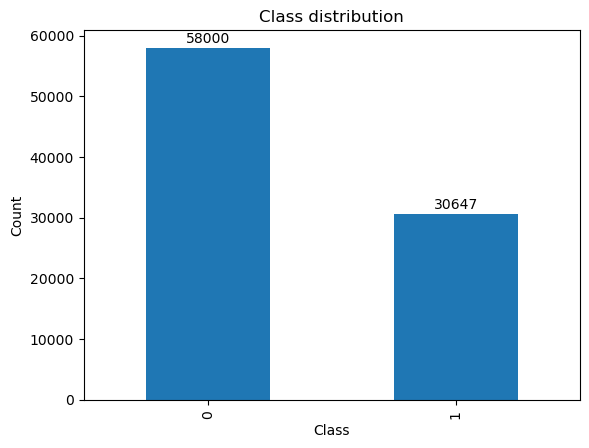


Percentage Distribution:


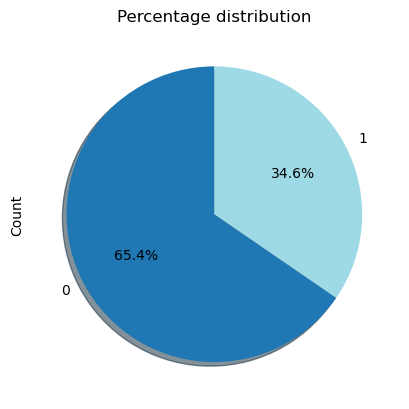

14:03:57.393 | INFO    | Task run 'distribution_plotter-3e8' - Task 'distribution_plotter' completed in 0.82 seconds

14:03:57.401 | INFO    | Task run 'distribution_plotter-3e8' - Finished in state Completed()

Total missing values: 0
Duplicate: 1438

                        count      mean       std  min  25%  50%  75%   max
qty_dot_url           88647.0  2.191343  1.235636  1.0  2.0  2.0  2.0  24.0
qty_hyphen_url        88647.0  0.328810  1.119286  0.0  0.0  0.0  0.0  35.0
qty_underline_url     88647.0  0.113879  0.657767  0.0  0.0  0.0  0.0  21.0
qty_slash_url         88647.0  1.281781  1.893929  0.0  0.0  0.0  2.0  44.0
qty_questionmark_url  88647.0  0.009329  0.112568  0.0  0.0  0.0  0.0   9.0
...                       ...       ...       ...  ...  ...  ...  ...   ...
qty_redirects         88647.0  0.343903  0.783892 -1.0  0.0  0.0  1.0  17.0
url_google_index      88647.0  0.001410  0.058640 -1.0  0.0  0.0  0.0   1.0
domain_google_index   88647.0  0.002019  0.063250 -1.0  0.0  0.0  0.0   1.0
url_shortened         88647.0  0.005482  0.073841  0.0  0.0  0.0  0.0   1.0
phishing              88647.0  0.345720  0.475605  0.0  0.0  0.0  1.0   1.0

[112 rows x 8 columns]


14:03:58.683 | INFO    | Task run 'descriptor-d99' - Task 'descriptor' completed in 0.79 seconds

14:03:58.699 | INFO    | Task run 'descriptor-d99' - Finished in state Completed()

qty_slash_directory           0.746454
qty_questionmark_directory    0.745644
qty_questionmark_file         0.745644
qty_slash_file                0.745644
qty_dollar_file               0.745644
qty_hashtag_file              0.745644
qty_hashtag_directory         0.745644
qty_at_file                   0.745509
qty_exclamation_file          0.745059
qty_and_file                  0.744860
qty_tilde_file                0.744657
qty_equal_file                0.743692
qty_space_file                0.742749
qty_comma_file                0.742364
qty_comma_directory           0.742251
Name: phishing, dtype: float64


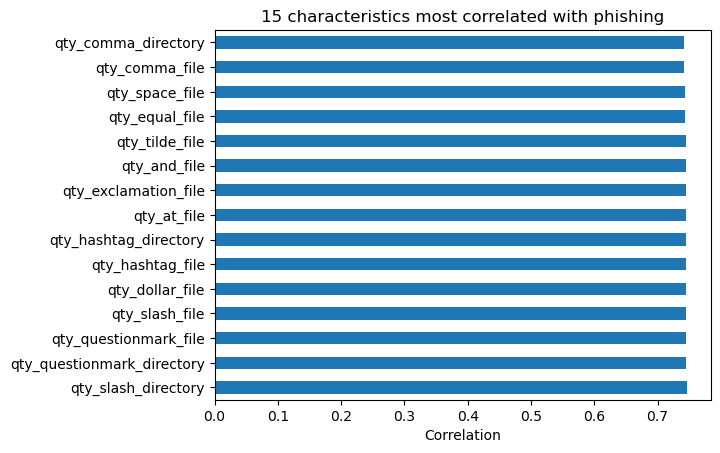

14:04:03.167 | INFO    | Task run 'correlation-84b' - Task 'correlation' completed in 3.99 seconds

14:04:03.174 | INFO    | Task run 'correlation-84b' - Finished in state Completed()


X (Features): (88647, 111)
y (Target): (88647,)
Tamaño de X_train: (70917, 111)
Tamaño de y_train: (70917,)
Tamaño de X_test: (17730, 111)
Tamaño de y_test: (17730,)


14:04:03.836 | INFO    | Task run 'preprocessing-293' - Task 'preprocessing' completed in 0.19 seconds

14:04:03.848 | INFO    | Task run 'preprocessing-293' - Finished in state Completed()

Class Distribution:


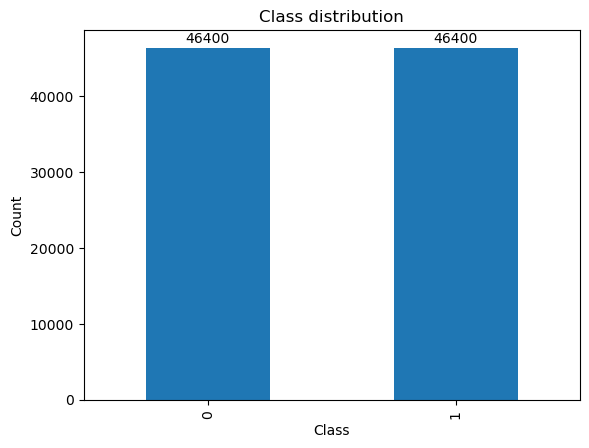

14:04:10.283 | INFO    | Task run 'smote-fc3' - SMOTE aplicado: 70917 -> 92800 muestras

14:04:10.292 | INFO    | Task run 'smote-fc3' - Task 'smote' completed in 5.67 seconds

14:04:10.299 | INFO    | Task run 'smote-fc3' - Finished in state Completed()

Gradient Boosting
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
18921  

14:08:45.817 | INFO    | Task run 'gradient_boosting-f49' - Task 'gradient_boosting' completed in 274.80 seconds

14:08:45.820 | INFO    | Task run 'gradient_boosting-f49' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[10964   636]
 [  273  5857]]


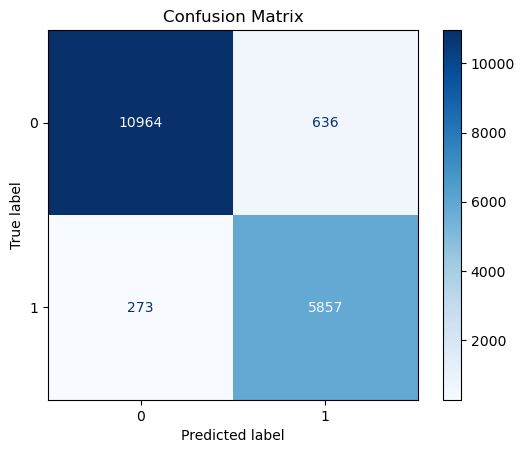

14:08:46.069 | INFO    | Task run 'confusion_matrix-e48' - Task 'confusion_matrix' completed in 0.13 seconds

14:08:46.074 | INFO    | Task run 'confusion_matrix-e48' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11600
           1       0.90      0.96      0.93      6130

    accuracy                           0.95     17730
   macro avg       0.94      0.95      0.94     17730
weighted avg       0.95      0.95      0.95     17730



14:08:46.235 | INFO    | Task run 'show_classificationreport-4a6' - Task 'show_classificationreport' completed in 0.03 seconds

14:08:46.242 | INFO    | Task run 'show_classificationreport-4a6' - Finished in state Completed()

AUC-ROC: 0.9891


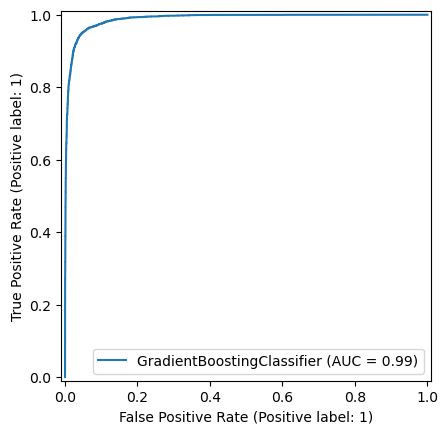

14:08:46.506 | INFO    | Task run 'roc_curve_analysis-ae7' - Task 'roc_curve_analysis' completed in 0.15 seconds

14:08:46.512 | INFO    | Task run 'roc_curve_analysis-ae7' - Finished in state Completed()

c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\ensemble\_gb.py", line

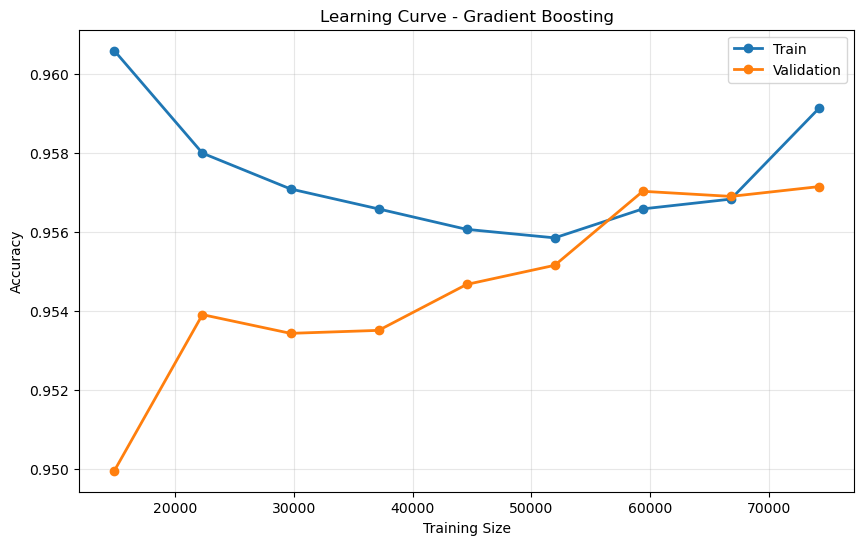

14:10:41.040 | INFO    | Task run 'plot_learning_curve-cde' - Task 'plot_learning_curve' completed in 114.28 seconds

14:10:41.043 | INFO    | Task run 'plot_learning_curve-cde' - Finished in state Completed()

Random Forest

Resultados de la validación cruzada en Random Forest: [0.97219828 0.96837284 0.97306034 0.98189655 0.98248922]
Resultado promedio de la validación cruzada en Random Forest: 0.9756
Exactitud (accuracy) en prueba (testing) del Random Forest: 0.9689791314156796


14:11:32.113 | INFO    | Task run 'random_forest-ba3' - Task 'random_forest' completed in 50.73 seconds

14:11:32.117 | INFO    | Task run 'random_forest-ba3' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[11260   340]
 [  210  5920]]


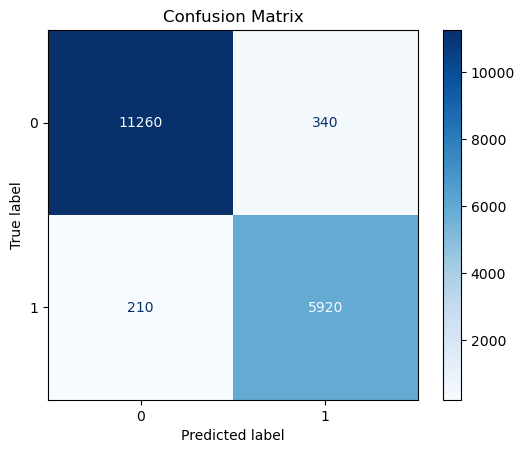

14:11:32.771 | INFO    | Task run 'confusion_matrix-1b5' - Task 'confusion_matrix' completed in 0.34 seconds

14:11:32.775 | INFO    | Task run 'confusion_matrix-1b5' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11600
           1       0.95      0.97      0.96      6130

    accuracy                           0.97     17730
   macro avg       0.96      0.97      0.97     17730
weighted avg       0.97      0.97      0.97     17730



14:11:33.274 | INFO    | Task run 'show_classificationreport-36a' - Task 'show_classificationreport' completed in 0.22 seconds

14:11:33.278 | INFO    | Task run 'show_classificationreport-36a' - Finished in state Completed()

AUC-ROC: 0.9948


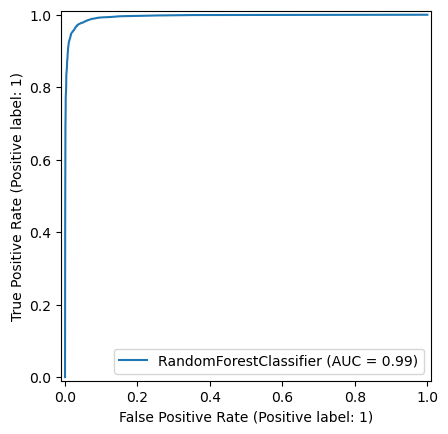

14:11:34.106 | INFO    | Task run 'roc_curve_analysis-3a7' - Task 'roc_curve_analysis' completed in 0.54 seconds

14:11:34.111 | INFO    | Task run 'roc_curve_analysis-3a7' - Finished in state Completed()

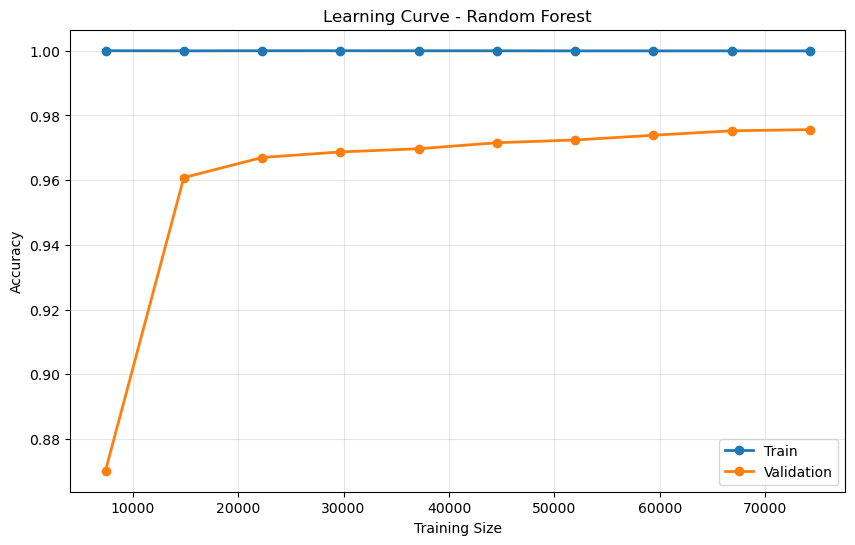

14:12:32.775 | INFO    | Task run 'plot_learning_curve-a79' - Task 'plot_learning_curve' completed in 58.23 seconds

14:12:32.779 | INFO    | Task run 'plot_learning_curve-a79' - Finished in state Completed()

Knn
Comparación de hiperparámetros:
KNN (n_neighbors=1) - Prueba de accuracy: 0.8888
KNN (n_neighbors=3) - Prueba de accuracy: 0.8782
KNN (n_neighbors=5) - Prueba de accuracy: 0.8703
KNN (n_neighbors=7) - Prueba de accuracy: 0.8647
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
556

14:13:07.036 | INFO    | Task run 'knn-191' - Task 'knn' completed in 33.90 seconds

14:13:07.043 | INFO    | Task run 'knn-191' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[10020  1580]
 [  818  5312]]


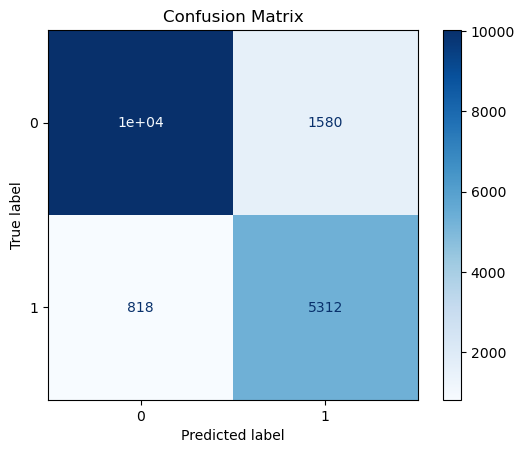

14:13:10.540 | INFO    | Task run 'confusion_matrix-1e7' - Task 'confusion_matrix' completed in 3.25 seconds

14:13:10.540 | INFO    | Task run 'confusion_matrix-1e7' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     11600
           1       0.77      0.87      0.82      6130

    accuracy                           0.86     17730
   macro avg       0.85      0.87      0.85     17730
weighted avg       0.87      0.86      0.87     17730



14:13:14.041 | INFO    | Task run 'show_classificationreport-15a' - Task 'show_classificationreport' completed in 3.25 seconds

14:13:14.046 | INFO    | Task run 'show_classificationreport-15a' - Finished in state Completed()

AUC-ROC: 0.9331


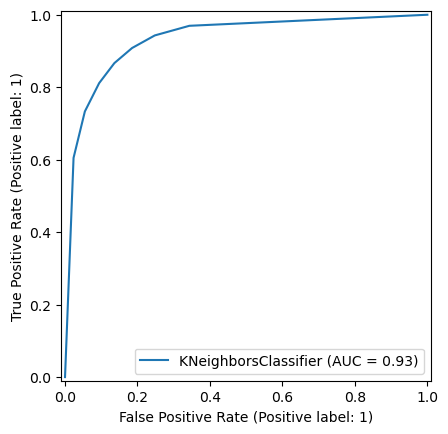

14:13:20.798 | INFO    | Task run 'roc_curve_analysis-f58' - Task 'roc_curve_analysis' completed in 6.52 seconds

14:13:20.798 | INFO    | Task run 'roc_curve_analysis-f58' - Finished in state Completed()

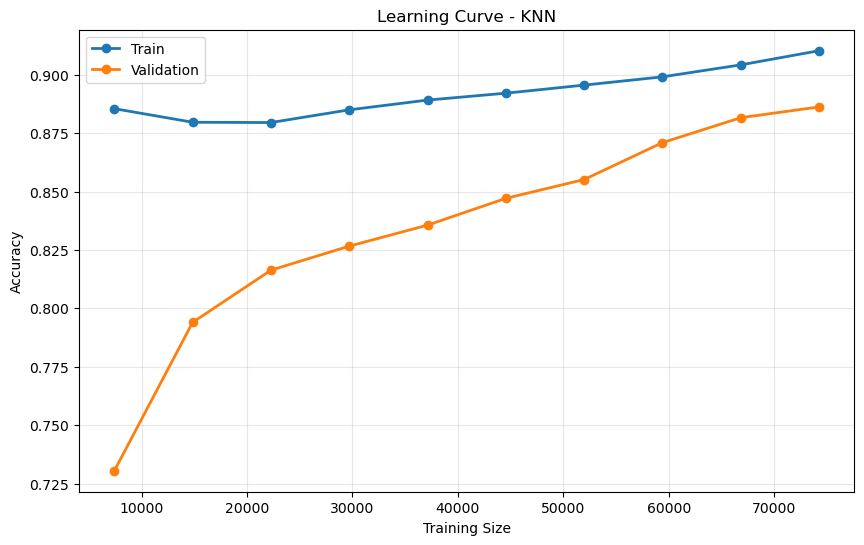

14:16:57.734 | INFO    | Task run 'plot_learning_curve-e1d' - Task 'plot_learning_curve' completed in 216.56 seconds

14:16:57.744 | INFO    | Task run 'plot_learning_curve-e1d' - Finished in state Completed()

Knn Scaler
KNN Scaler(n_neighbors=1) - Prueba de accuracy: 0.9503
KNN Scaler(n_neighbors=3) - Prueba de accuracy: 0.9510
KNN Scaler(n_neighbors=5) - Prueba de accuracy: 0.9513
KNN Scaler(n_neighbors=7) - Prueba de accuracy: 0.9505
Comparación de predicciones:
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                  

14:17:32.184 | INFO    | Task run 'knn_scaler-e37' - Task 'knn_scaler' completed in 34.07 seconds

14:17:32.189 | INFO    | Task run 'knn_scaler-e37' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[11054   546]
 [  317  5813]]


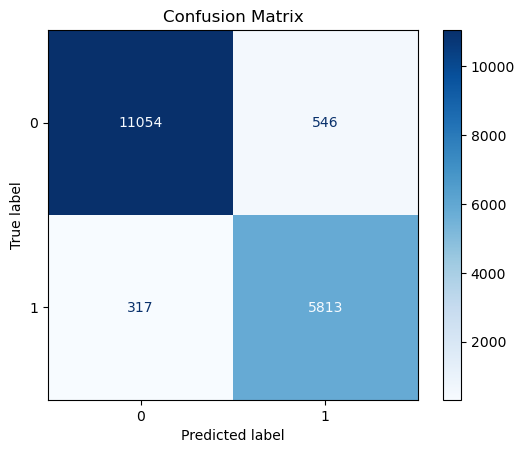

14:17:35.788 | INFO    | Task run 'confusion_matrix-bd0' - Task 'confusion_matrix' completed in 3.40 seconds

14:17:35.793 | INFO    | Task run 'confusion_matrix-bd0' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     11600
           1       0.91      0.95      0.93      6130

    accuracy                           0.95     17730
   macro avg       0.94      0.95      0.95     17730
weighted avg       0.95      0.95      0.95     17730



14:17:39.338 | INFO    | Task run 'show_classificationreport-cf5' - Task 'show_classificationreport' completed in 3.34 seconds

14:17:39.347 | INFO    | Task run 'show_classificationreport-cf5' - Finished in state Completed()

AUC-ROC: 0.9807


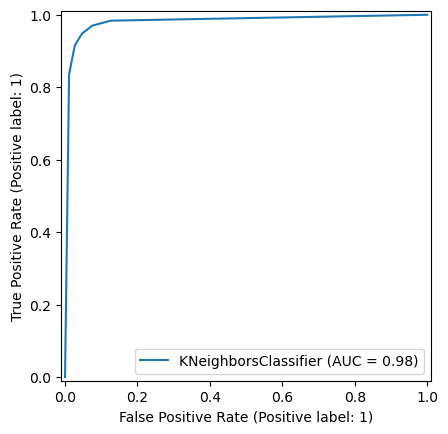

14:17:46.257 | INFO    | Task run 'roc_curve_analysis-29f' - Task 'roc_curve_analysis' completed in 6.72 seconds

14:17:46.262 | INFO    | Task run 'roc_curve_analysis-29f' - Finished in state Completed()

SVM
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
18921                

15:08:12.918 | INFO    | Task run 'svm-0b5' - Task 'svm' completed in 3026.28 seconds

15:08:12.923 | INFO    | Task run 'svm-0b5' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[8113 3487]
 [1100 5030]]


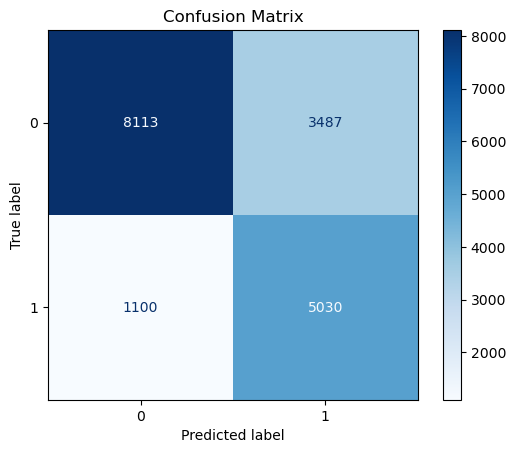

15:10:04.998 | INFO    | Task run 'confusion_matrix-102' - Task 'confusion_matrix' completed in 111.86 seconds

15:10:05.003 | INFO    | Task run 'confusion_matrix-102' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.88      0.70      0.78     11600
           1       0.59      0.82      0.69      6130

    accuracy                           0.74     17730
   macro avg       0.74      0.76      0.73     17730
weighted avg       0.78      0.74      0.75     17730



15:11:48.114 | INFO    | Task run 'show_classificationreport-85a' - Task 'show_classificationreport' completed in 102.90 seconds

15:11:48.120 | INFO    | Task run 'show_classificationreport-85a' - Finished in state Completed()

AUC-ROC: 0.8128


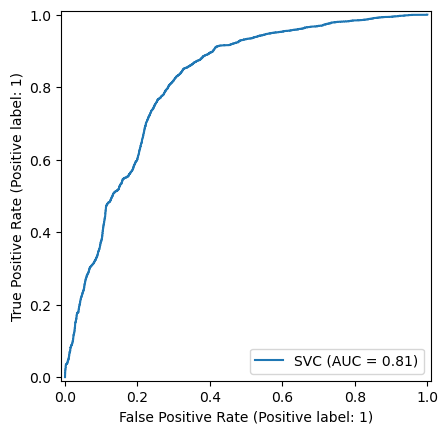

15:15:02.741 | INFO    | Task run 'roc_curve_analysis-a19' - Task 'roc_curve_analysis' completed in 194.42 seconds

15:15:02.741 | INFO    | Task run 'roc_curve_analysis-a19' - Finished in state Completed()

SVM Scaler
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
18921         

15:26:28.342 | INFO    | Task run 'svm_scaler-101' - Task 'svm_scaler' completed in 685.24 seconds

15:26:28.347 | INFO    | Task run 'svm_scaler-101' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[10873   727]
 [  338  5792]]


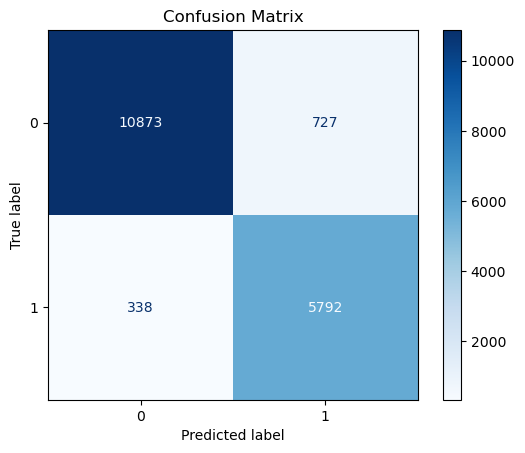

15:26:52.797 | INFO    | Task run 'confusion_matrix-bc4' - Task 'confusion_matrix' completed in 24.38 seconds

15:26:52.801 | INFO    | Task run 'confusion_matrix-bc4' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11600
           1       0.89      0.94      0.92      6130

    accuracy                           0.94     17730
   macro avg       0.93      0.94      0.93     17730
weighted avg       0.94      0.94      0.94     17730



15:27:17.057 | INFO    | Task run 'show_classificationreport-d7f' - Task 'show_classificationreport' completed in 24.18 seconds

15:27:17.063 | INFO    | Task run 'show_classificationreport-d7f' - Finished in state Completed()

AUC-ROC: 0.9838


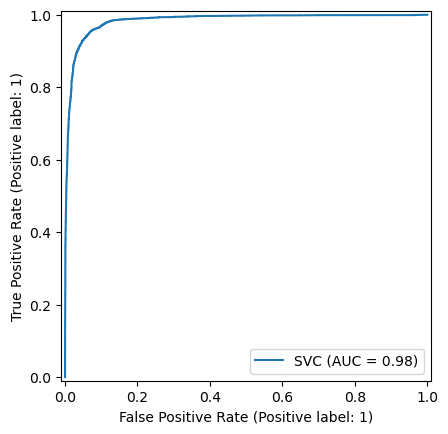

15:28:05.499 | INFO    | Task run 'roc_curve_analysis-821' - Task 'roc_curve_analysis' completed in 48.35 seconds

15:28:05.502 | INFO    | Task run 'roc_curve_analysis-821' - Finished in state Completed()

SVM con LinearSVC
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
18921  

15:28:14.110 | INFO    | Task run 'svm_linearsvc-523' - Task 'svm_linearsvc' completed in 8.22 seconds

15:28:14.119 | INFO    | Task run 'svm_linearsvc-523' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[10255  1345]
 [  333  5797]]


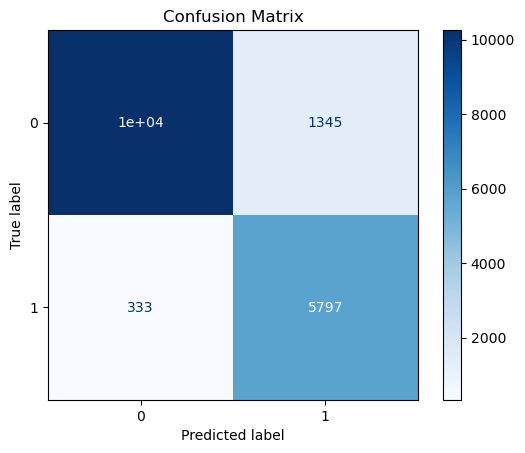

15:28:14.349 | INFO    | Task run 'confusion_matrix-db6' - Task 'confusion_matrix' completed in 0.11 seconds

15:28:14.354 | INFO    | Task run 'confusion_matrix-db6' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     11600
           1       0.81      0.95      0.87      6130

    accuracy                           0.91     17730
   macro avg       0.89      0.91      0.90     17730
weighted avg       0.91      0.91      0.91     17730



15:28:14.501 | INFO    | Task run 'show_classificationreport-cca' - Task 'show_classificationreport' completed in 0.02 seconds

15:28:14.502 | INFO    | Task run 'show_classificationreport-cca' - Finished in state Completed()

AUC-ROC: 0.9685


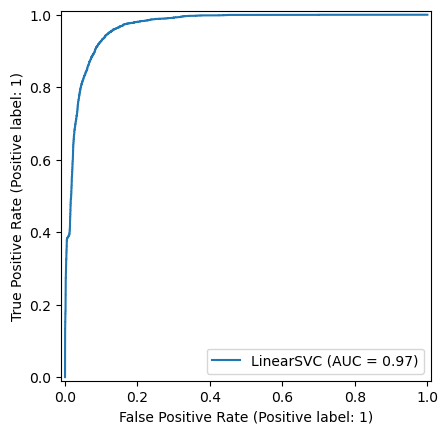

15:28:14.743 | INFO    | Task run 'roc_curve_analysis-2c6' - Task 'roc_curve_analysis' completed in 0.10 seconds

15:28:14.755 | INFO    | Task run 'roc_curve_analysis-2c6' - Finished in state Completed()

c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\svm\_classes.py", line

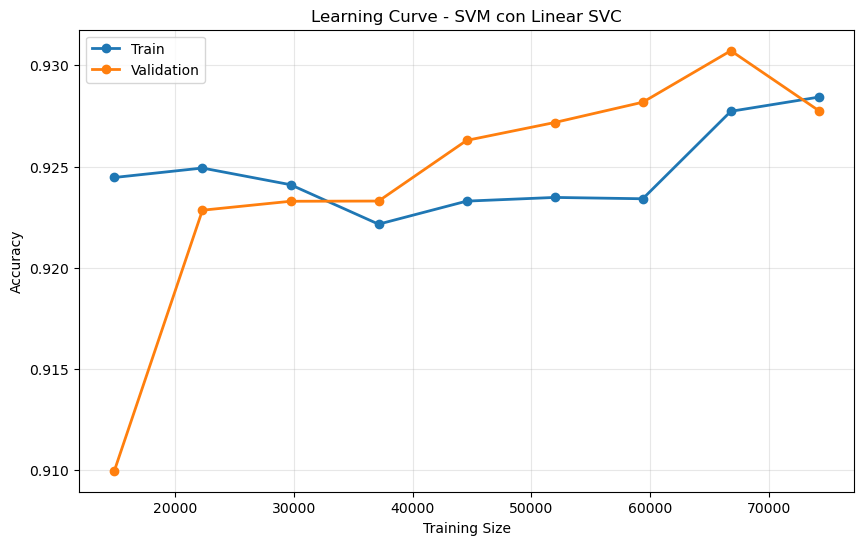

15:28:48.306 | INFO    | Task run 'plot_learning_curve-ba7' - Task 'plot_learning_curve' completed in 33.29 seconds

15:28:48.306 | INFO    | Task run 'plot_learning_curve-ba7' - Finished in state Completed()

SVM Scaler con LinearSVC
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \


15:29:10.220 | INFO    | Task run 'svm_scalerlinear-8b1' - Task 'svm_scalerlinear' completed in 21.54 seconds

15:29:10.229 | INFO    | Task run 'svm_scalerlinear-8b1' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[10546  1054]
 [  352  5778]]


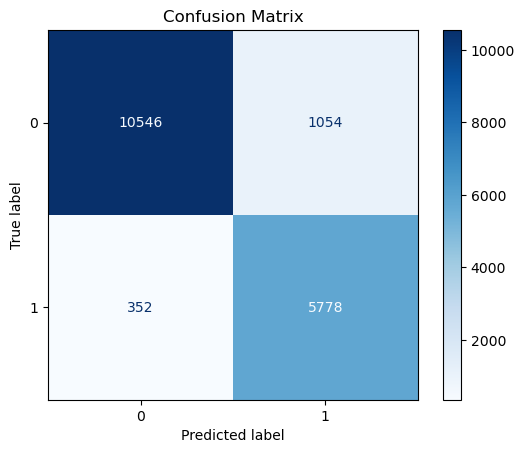

15:29:10.380 | INFO    | Task run 'confusion_matrix-e9e' - Task 'confusion_matrix' completed in 0.10 seconds

15:29:10.384 | INFO    | Task run 'confusion_matrix-e9e' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     11600
           1       0.85      0.94      0.89      6130

    accuracy                           0.92     17730
   macro avg       0.91      0.93      0.91     17730
weighted avg       0.93      0.92      0.92     17730



15:29:10.442 | INFO    | Task run 'show_classificationreport-ea3' - Task 'show_classificationreport' completed in 0.01 seconds

15:29:10.447 | INFO    | Task run 'show_classificationreport-ea3' - Finished in state Completed()

AUC-ROC: 0.9781


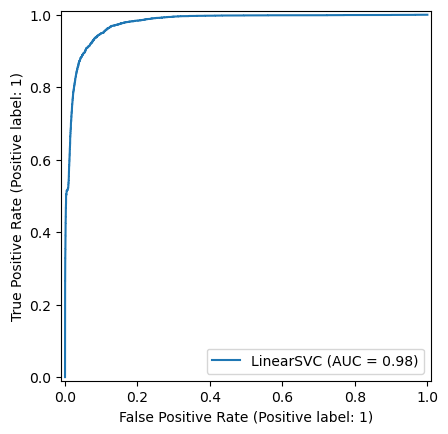

15:29:10.617 | INFO    | Task run 'roc_curve_analysis-27f' - Task 'roc_curve_analysis' completed in 0.11 seconds

15:29:10.622 | INFO    | Task run 'roc_curve_analysis-27f' - Finished in state Completed()

Logistic Regression


c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
18921                   

c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Resultados de la validación cruzada: [0.72 0.72 0.72 0.72 0.73]
Resultado promedio de la validación cruzada: 0.7236
Exactitud (accuracy) en prueba (testing): 0.7209


c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15:36:51.475 | INFO    | Task run 'logistic_regression-870' - Task 'logistic_regression' completed in 460.46 seconds

15:36:51.480 | INFO    | Task run 'logistic_regression-870' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[8154 3446]
 [1503 4627]]


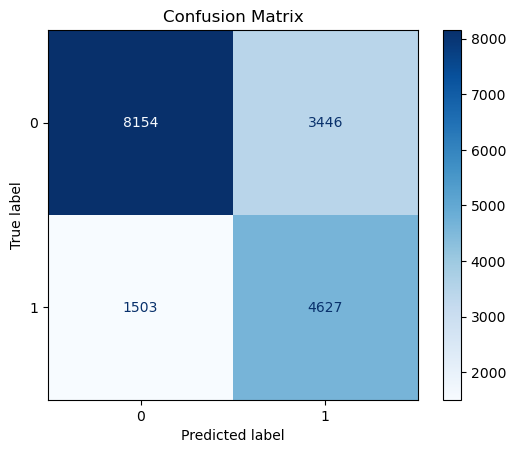

15:36:51.722 | INFO    | Task run 'confusion_matrix-4a1' - Task 'confusion_matrix' completed in 0.11 seconds

15:36:51.726 | INFO    | Task run 'confusion_matrix-4a1' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.84      0.70      0.77     11600
           1       0.57      0.75      0.65      6130

    accuracy                           0.72     17730
   macro avg       0.71      0.73      0.71     17730
weighted avg       0.75      0.72      0.73     17730



15:36:51.866 | INFO    | Task run 'show_classificationreport-a7d' - Task 'show_classificationreport' completed in 0.02 seconds

15:36:51.869 | INFO    | Task run 'show_classificationreport-a7d' - Finished in state Completed()

AUC-ROC: 0.8335


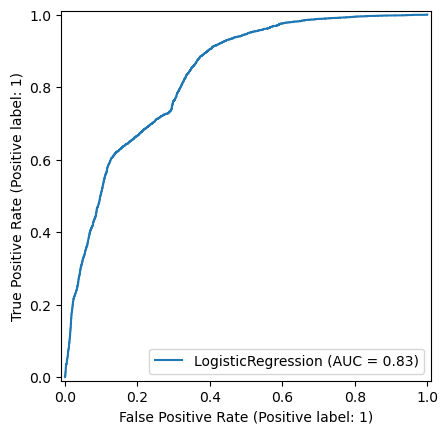

15:36:52.098 | INFO    | Task run 'roc_curve_analysis-685' - Task 'roc_curve_analysis' completed in 0.11 seconds

15:36:52.102 | INFO    | Task run 'roc_curve_analysis-685' - Finished in state Completed()

c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\linear_model\_logistic

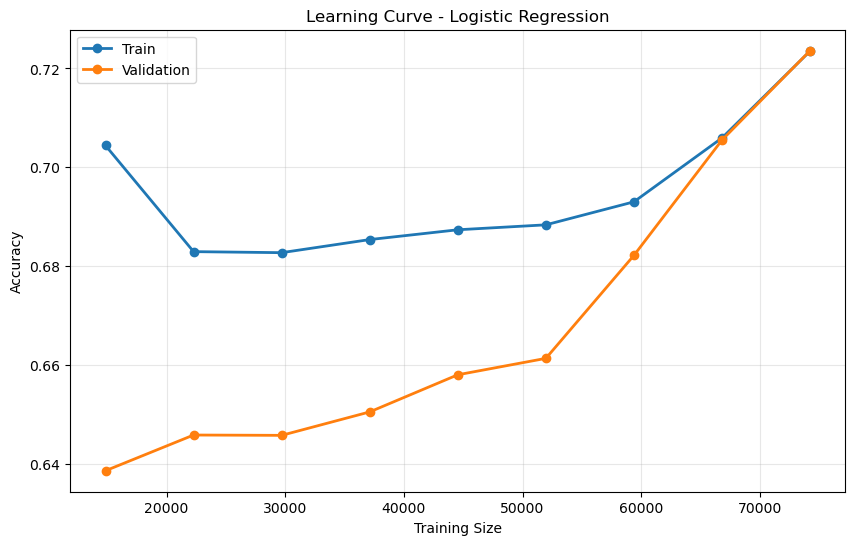

15:43:37.219 | INFO    | Task run 'plot_learning_curve-12e' - Task 'plot_learning_curve' completed in 404.87 seconds

15:43:37.223 | INFO    | Task run 'plot_learning_curve-12e' - Finished in state Completed()

Logistic Regression Scaler

Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
18921            3               1                  0              3   
74673            3               0                  0              0   
19334            1               1                  0              5   
55653            2               0                  0              0   
39341            2               0                  1              3   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
18921                     0              0           0            0   
74673                     0              0           0            0   
19334                     0              0           0            0   
55653                     0              0           0            0   
39341                     0              3           0            2   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers 

15:43:46.923 | INFO    | Task run 'logistic_regression_scaler-766' - Task 'logistic_regression_scaler' completed in 9.34 seconds

15:43:46.932 | INFO    | Task run 'logistic_regression_scaler-766' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[10656   944]
 [  392  5738]]


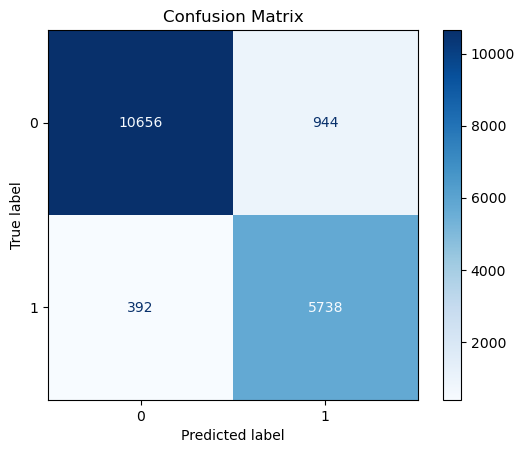

15:43:47.063 | INFO    | Task run 'confusion_matrix-2d5' - Task 'confusion_matrix' completed in 0.09 seconds

15:43:47.072 | INFO    | Task run 'confusion_matrix-2d5' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     11600
           1       0.86      0.94      0.90      6130

    accuracy                           0.92     17730
   macro avg       0.91      0.93      0.92     17730
weighted avg       0.93      0.92      0.93     17730



15:43:47.131 | INFO    | Task run 'show_classificationreport-f20' - Task 'show_classificationreport' completed in 0.01 seconds

15:43:47.135 | INFO    | Task run 'show_classificationreport-f20' - Finished in state Completed()

AUC-ROC: 0.9785


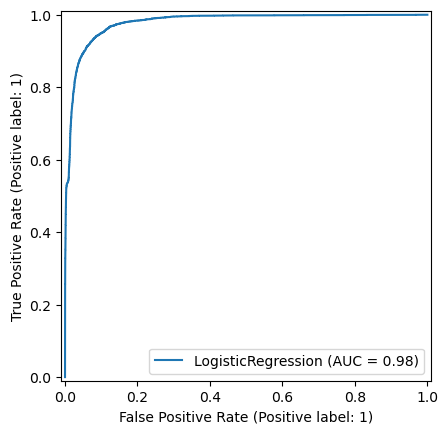

15:43:47.572 | INFO    | Task run 'roc_curve_analysis-9cd' - Task 'roc_curve_analysis' completed in 0.39 seconds

15:43:47.580 | INFO    | Task run 'roc_curve_analysis-9cd' - Finished in state Completed()

c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


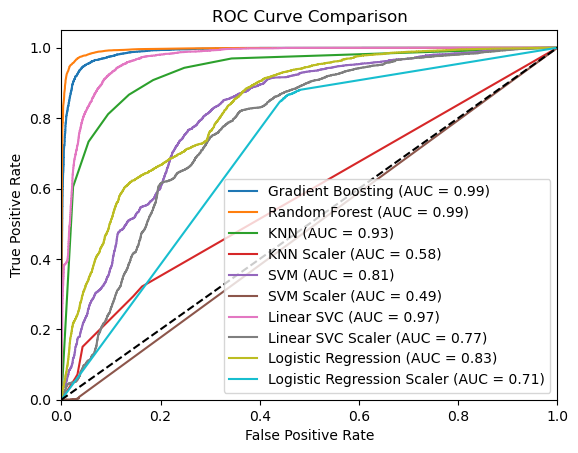

15:45:57.170 | INFO    | Task run 'multiple_roc-943' - Task 'multiple_roc' completed in 128.77 seconds

15:45:57.197 | INFO    | Task run 'multiple_roc-943' - Finished in state Completed()

c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
c:\Users\aleja\miniconda3\envs\ml1\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


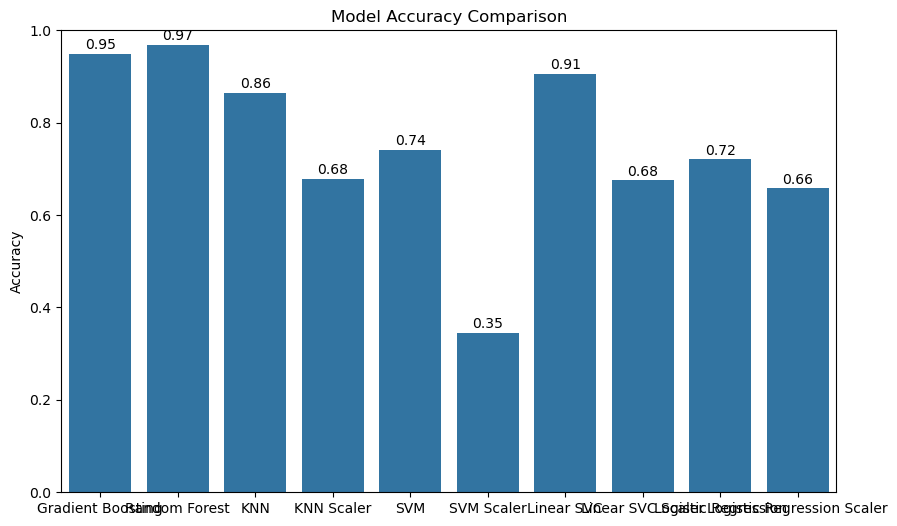

15:48:06.926 | INFO    | Task run 'bar_chart-20a' - Task 'bar_chart' completed in 128.97 seconds

15:48:06.930 | INFO    | Task run 'bar_chart-20a' - Finished in state Completed()

15:48:06.998 | INFO    | Flow run 'authentic-baboon' - Finished in state Completed()

In [27]:
@flow
def full_dataset_flow():
    df = load_data()
    distribution_plotter(df)
    descriptor(df)
    correlation(df)
    X_train, X_test, y_train, y_test = preprocessing(df)

    X_train_balanced, y_train_balanced = smote(X_train, y_train)

    class_names = [0,1]

    gb_model = gradient_boosting(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, gb_model, X_test, y_test)
    show_classificationreport(gb_model, X_test, y_test, class_names)
    roc_curve_analysis(gb_model, X_test, y_test)
    plot_learning_curve(gb_model, X_train_balanced, y_train_balanced, "Gradient Boosting")

    rf_model = random_forest(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, rf_model, X_test, y_test)
    show_classificationreport(rf_model, X_test, y_test, class_names)
    roc_curve_analysis(rf_model, X_test, y_test)
    plot_learning_curve(rf_model, X_train_balanced, y_train_balanced, "Random Forest")

    knn_model = knn(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, knn_model, X_test, y_test)
    show_classificationreport(knn_model, X_test, y_test, class_names)
    roc_curve_analysis(knn_model, X_test, y_test)
    plot_learning_curve(knn_model, X_train_balanced, y_train_balanced, "KNN")

    knn_scaled, x_testscal_knn = knn_scaler(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, knn_scaled, x_testscal_knn, y_test)
    show_classificationreport(knn_scaled, x_testscal_knn, y_test, class_names)
    roc_curve_analysis(knn_scaled, x_testscal_knn, y_test)

    svm_class_model = svm(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, svm_class_model, X_test, y_test)
    show_classificationreport(svm_class_model, X_test, y_test, class_names)
    roc_curve_analysis(svm_class_model, X_test, y_test)

    svm_class_scaled, x_testscal_svm = svm_scaler(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, svm_class_scaled, x_testscal_svm, y_test)
    show_classificationreport(svm_class_scaled, x_testscal_svm, y_test, class_names)
    roc_curve_analysis(svm_class_scaled, x_testscal_svm, y_test)

    linear_svmmodel = svm_linearsvc(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, linear_svmmodel, X_test, y_test)
    show_classificationreport(linear_svmmodel, X_test, y_test, class_names)
    roc_curve_analysis(linear_svmmodel, X_test, y_test)
    plot_learning_curve(linear_svmmodel, X_train_balanced, y_train_balanced, "SVM con Linear SVC")

    linear_svm_scaled, X_test_scaled_linear = svm_scalerlinear(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, linear_svm_scaled, X_test_scaled_linear, y_test)
    show_classificationreport(linear_svm_scaled, X_test_scaled_linear, y_test, class_names)
    roc_curve_analysis(linear_svm_scaled, X_test_scaled_linear, y_test)

    lr_model = logistic_regression(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, lr_model, X_test, y_test)
    show_classificationreport(lr_model, X_test, y_test, class_names)
    roc_curve_analysis(lr_model, X_test, y_test)
    plot_learning_curve(lr_model, X_train_balanced, y_train_balanced, "Logistic Regression")

    lr_scaled, X_testscaled_lr = logistic_regression_scaler(X_train_balanced, X_test, y_train_balanced, y_test)
    confusion_matrix(class_names, lr_scaled, X_testscaled_lr, y_test)
    show_classificationreport(lr_scaled, X_testscaled_lr, y_test, class_names)
    roc_curve_analysis(lr_scaled, X_testscaled_lr, y_test)

    models_dict = {
        "Gradient Boosting": gb_model,
        "Random Forest": rf_model,
        "KNN": knn_model,
        "KNN Scaler": knn_scaled,
        "SVM": svm_class_model,
        "SVM Scaler": svm_class_scaled,
        "Linear SVC": linear_svmmodel,
        "Linear SVC Scaler": linear_svm_scaled,
        "Logistic Regression": lr_model,
        "Logistic Regression Scaler": lr_scaled,
    }

    multiple_roc(models_dict, X_test, y_test)
    bar_chart(models_dict, X_test, y_test)

full_dataset_flow()